In [23]:
get_ipython().magic('matplotlib inline')
import pandas;
import matplotlib;
import matplotlib.pyplot as plt
import scipy.io;
import numpy as np
from matplotlib.pylab import rcParams
import math
from scipy import signal
from scipy.fftpack import fft, fftshift
import scipy.stats
from scipy.ndimage import filters

from scipy.stats import norm
from scipy.stats import describe
from sklearn.neighbors import KernelDensity

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300;
rcParams['lines.linewidth'] = 2.2;
plt.style.use('default')
# get_ipython().magic('pdb')

In [2]:
plt.style.available

['seaborn-deep',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-dark',
 'seaborn-talk',
 'seaborn-paper',
 'fivethirtyeight',
 'seaborn-white',
 'seaborn-muted',
 'classic',
 'seaborn-pastel',
 'ggplot',
 'grayscale',
 'seaborn-ticks',
 'seaborn-poster',
 'bmh',
 'seaborn-darkgrid',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-notebook',
 'seaborn-dark-palette']

In [3]:
def synthetic_neuron(drive):
    """
    Simulates a mock neuron with a time step of 1ms.
    Arguments:
    drive - input to the neuron (expect zero mean; SD=1)
    Returns:
    rho - response function (0=non-spike and 1=spike at each time step)
    """
    dt = .001
    T = dt*len(drive)
    time = np.arange(0, T, dt)
    lagSteps = .02/dt
    drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:])) 
    system = scipy.signal.lti([1], [.03**2, 2*.03, 1])
    _, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time) 
    rate = np.divide(30, 1 + np.exp(50*(.05-L)))
    spikeProb = rate*dt
    return np.random.rand(len(spikeProb)) < spikeProb

def gaussian(x, mu, var):
    return np.exp(-np.power(x-mu, 2.)/(2*var))

def plot_spike_raster(trial, spikeTimes, ax):
    rep_trials = np.repeat(trial, np.size(spikeTimes))
    sizes = np.ones(len(spikeTimes))*60;
    ax.axhline(y=trial, linewidth=0.3);
    ax.scatter(spikeTimes, np.array([rep_trials]), marker='|', alpha=0.9,
               color='black', s=sizes);

def plot_psth(spikeTimes, num_bins, ax2, **kwargs):
    counts = ax2.hist(spikeTimes, bins = num_bins, **kwargs);
    hist1, bin1 = np.histogram(spikeTimes, bins=num_bins)
    bincens = 0.5*(bin1[1:] + bin1[:-1])
    ax2.plot(bincens, hist1, alpha=0.8);
    return counts;

def set_axis_range(series, func):
    minmax = scipy.stats.describe(series).minmax;
    func([math.floor(minmax[0]-minmax[0]/5), math.ceil(minmax[1]+minmax[1]/5)])

## 1a
Load the synthetic data file MT direction tuning. The file contains two
variables: “direction” is a list of stimulus directions for 200 trials.

In [4]:
tuning_data = scipy.io.loadmat('MT direction tuning.mat');

In [5]:
sptimes = 1000*tuning_data['spikeTimes'][0];
directions = tuning_data['direction'];
# print(directions.shape, sptimes.shape)
num_rows = np.array([x.shape[1] for x in sptimes]).sum();
df_cols = ['trial','direction', 'timestamp'];
sp_tr_list = [];
for j in range(0, directions.shape[1]):
    sp_tr = sptimes[j].T;
    direcn = directions[:, j];
    for k in range(0, sp_tr.shape[0]):
        sp = sp_tr[k,:];
        dict1 = {'trial': j+1, 'direction': direcn.tolist()[0], 
                 'timestamp': sp.tolist()[0]};
        sp_tr_list.append(dict1);
df = pandas.DataFrame(sp_tr_list, index=np.arange(0, num_rows), columns = df_cols);

## 1b 
Plot the spike raster and multi trial firing rate (5ms bins) for 0° trials.
Trial length is 2s.

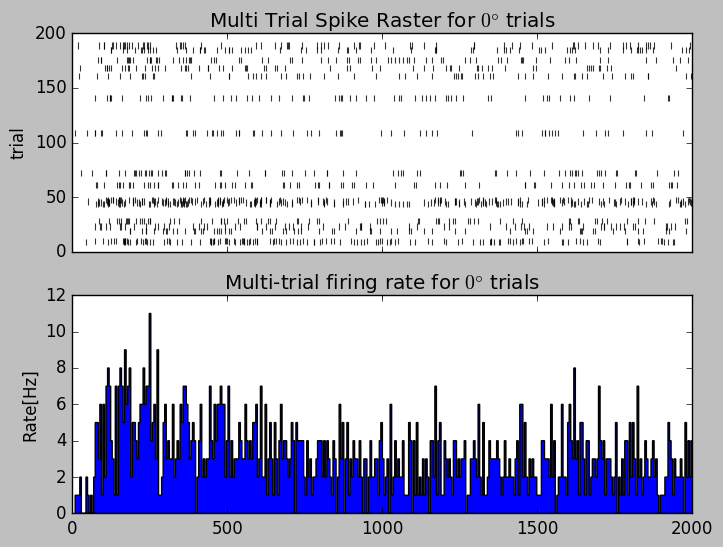

In [24]:
zrdf = df[df.direction==0]; zrdf.shape
f, ax = plt.subplots(2,1, sharex=True)
# f.tight_layout();
ax[0].set_xlim([0,2000])
ax[0].set_ylim([0,200])
ax[0].set_title('Multi Trial Spike Raster for $0\degree$ trials')

dt = 5; #5ms sampling
num_bins = 2000/dt; #5 ms bins
num_samples = 200; 
t_plot = np.arange(0, 2005, dt)
zrdf.plot.scatter(ax=ax[0], x='timestamp', y='trial', marker='|', alpha=0.8,
                   s=np.ones(len(zrdf))*20, linewidth=.8, color='k');


# counts, binedges = np.histogram(zrdf['timestamp'], bins=int(num_bins));

# counts = counts/(num_samples*(dt/1000));
# print(counts)
# center = (binedges[:-1] + binedges[1:]) / 2;
# width = (binedges[1]-binedges[0]);

# ax[1].bar(center, counts, align='center', width=width, color='g');
# # ax[1].plot(center, counts, linewidth=0.9)

aa = ax[1].hist(zrdf.timestamp, bins=num_bins, histtype='stepfilled');
ax[1].set_ylabel('Rate[Hz]');
ax[1].set_title('Multi-trial firing rate for $0\degree$ trials')
# print(str(describe(aa[0])) + '\n' + str(describe(counts)));
# aa[2].set_ydata
ax[1].set_xlabel('')


In [25]:
aa[0] == counts

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [7]:
width

4.9800000000000004

Use Gaussian window functions to generate single trial rate estimates

## 1c
Plot together the single trial rate estimate for trial 9 using a Gaussian
kernels with SD=5ms and SD=50ms. (Use an appropriate sampling period of your choice for which the rate fluctuations are not visibly distorted in the plot.)

902.815789474 (44.0, 1942.0) 76
0.000456479258072 (0.0, 0.0095440736938141781) (76,)
888.708304414 (178.52026427446697, 1793.3190725004847) (67,)


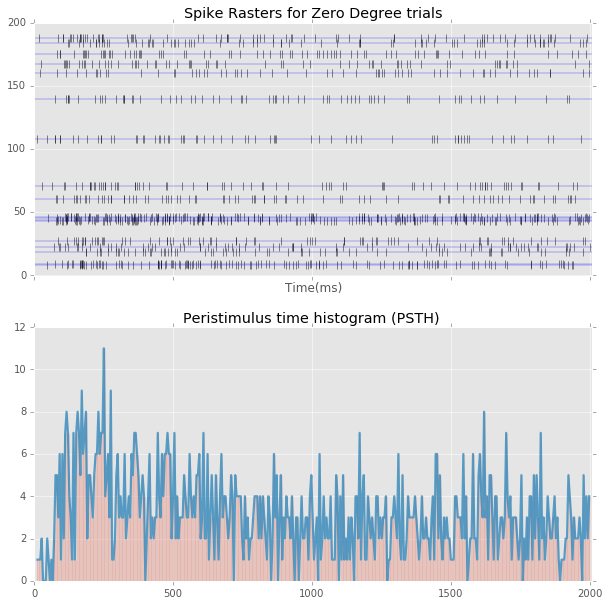

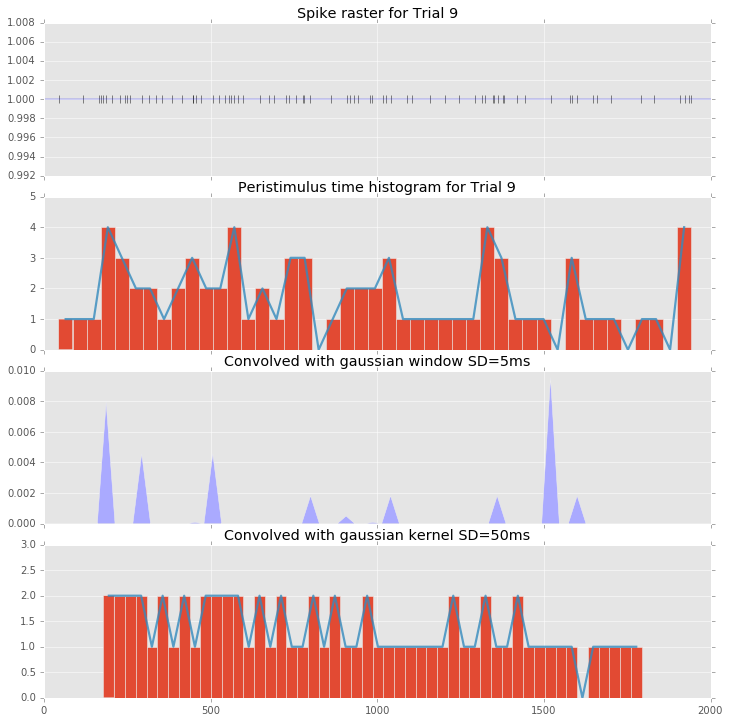

In [8]:
zero_deg_trial_indices = np.where(directions==0)[1];
zer_deg_trial_spike_times = sptimes[zero_deg_trial_indices];
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True);

# fig.tight_layout();
# ax.grid('on');
for trial, spikeTimes in zip(zero_deg_trial_indices, zer_deg_trial_spike_times):
    plot_spike_raster(trial, spikeTimes, ax);

ax.set_xlim([-0.05,2010])
ax.set_ylim([-1, 200])
ax.set_title("Spike Rasters for Zero Degree trials")
ax.set_xlabel('Time(ms)')
all_spikes = np.array(zer_deg_trial_spike_times[0])
for i in range(1, len(zer_deg_trial_spike_times)):
    all_spikes = np.concatenate((all_spikes, zer_deg_trial_spike_times[i]), axis=1);

pp = plot_psth(all_spikes[0], num_bins, ax2, alpha=0.3)
ax2.set_title('Peristimulus time histogram (PSTH) ')
# ax2.set_xlabel

num_bins = 45;
# trial_nine = zer_deg_trial_spike_times[zero_deg_trial_indices[1]].tolist()[0]
trial_nine = sptimes[8][0];

std_dev1 = 5;
std_dev2 = 50;
len_gauss = 10;

window1 = scipy.signal.gaussian(len_gauss, std=std_dev1, sym=True)
window1 /= window1.sum()
# window1 = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(trial_nin)

window2 = scipy.signal.gaussian(len_gauss, std=std_dev2, sym=True)
window2 /= window2.sum()



# import pdb; pdb.set_trace();
smoothed = np.convolve(trial_nine, window1, 'valid');

kde = KernelDensity(kernel='gaussian', bandwidth=0.55).fit(trial_nine[:, np.newaxis])
x_plot = np.linspace(0,2000,num=len(trial_nine))[:, np.newaxis]
smoothed = np.exp(kde.score_samples(x_plot));

smoothed2 = np.convolve(trial_nine, window2, 'valid');
# smoothed = smoothed[(len_gauss/2-1):-(len_gauss/2)]
# smoothed2 = smoothed2[(len_gauss/2-1):-(len_gauss/2)]

print(scipy.stats.describe(trial_nine).mean, scipy.stats.describe(trial_nine).minmax, len(trial_nine))
print(scipy.stats.describe(smoothed).mean, scipy.stats.describe(smoothed).minmax, smoothed.shape)
print(scipy.stats.describe(smoothed2).mean, scipy.stats.describe(smoothed2).minmax, smoothed2.shape)

f, (ax2,ax3,ax4,ax5) = plt.subplots(4,1, sharex=True);
f.tight_layout()

plot_spike_raster(1, trial_nine, ax2);
ax2.set_title('Spike raster for Trial 9');


pp = plot_psth(trial_nine, num_bins, ax3); cnts3 = pp[0]; bins3 = pp[1];
ax3.set_title('Peristimulus time histogram for Trial 9');
set_axis_range(cnts3, ax3.set_ylim)
ax3.set_ylabel('')

num_bins += 5;
# pp = plot_psth(smoothed, num_bins, ax4, alpha=0.4); cnts4 = pp[0]; bins4 = pp[1];
ax4.fill(x_plot[:, 0], smoothed, fc='#AAAAFF')
ax4.set_title('Convolved with gaussian window SD=5ms');
# set_axis_range(cnts4, ax4.set_ylim)

pp = plot_psth(smoothed2, num_bins, ax5); cnts5 = pp[0]; bins5=pp[1];
ax5.set_title('Convolved with gaussian kernel SD=50ms')
set_axis_range(cnts5, ax5.set_ylim);

In [9]:
xx = zrdf['timestamp'].tolist(); 
print(len(xx)); print(all_spikes[0].shape)

1275
(1275,)
